In [131]:
# from sympy import expand, symbols, simplify, factor
# import sympy as sp

# # State variables 
# m1, m2, d1, d2, n1, n2 = symbols('m1 m2 d1 d2 n1 n2', real=True)

# # Parameters
# wm, wd, Lm, Ld, alpha, beta, uptake_m, uptake_d, gamma_m, gamma_d, gamma_nm, gamma_nd, kappa, R, H = symbols('wm wd Lm Ld alpha beta uptake_m uptake_d gamma_m gamma_d gamma_nm gamma_nd kappa R H', real=True)



# h1 = R*H 
# h2 = H - h1     
hr2s = 1/3600



# #       advection        diffusion       loss      growth
# f1 =  (wm/h1)*m2  + kappa/h1 * (m2 - m1) - Lm*m1 + alpha*m1*(n1/(gamma_m + n1))    # surface Microcystis
# f2 = (-wm/h2)*m2  + kappa/h2 * (m1 - m2) - Lm*m2                     # bottom Microcystis
# f3 = -wd/h1*d1  + kappa/h1 * (d2 - d1) - Ld*d1 + beta*d1*(n1/(gamma_d + n1))      # surface diatoms
# f4 = wd/h2*d1   + kappa/h2 * (d1 - d2) - Ld*d2                       # bottom diatoms 
# f5 = kappa/h1 * (n2 - n1) - uptake_m*m1*(n1/(n1+gamma_nm))  - d1*uptake_d*(n1/(n1+gamma_nd))     # surface nutrients 
# # f6 = 0 
# # f6 = kappa/h2 * (n1 - n2)

# solution = sp.solve([f1, f2, f3, f4], [m1, m2, d1, d2], dict=True)
# solution = sp.solve([f1, f3], [m1, m2, d1, d2], dict=True)

# print(solution)
# for i, sol in enumerate(solution):
#     print(f"Solution {i+1}:")
#     for key, value in sol.items():
#         print(f"{key} = {simplify(value)}")
#         example = value #.subs({R: 0.5, H: 10, kappa: 1e-3, w: 1e-4, v: 1e-4, Lm:1e-5, Ld:1e-5, growth_m:1e-4, growth_d:1e-4}).evalf()
#         # print("\t" , example)


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import xarray as xr
import matplotlib.colors as mcolors
import cmocean as cmo

# Reload module
import importlib
import parameters as pm 
importlib.reload(pm)

cmap = cmo.cm.balance

dst = xr.open_dataset("population_dataset_time_2umol.nc")

N = len(dst.kappa)
NT = len(dst.t)
print(N)
print(NT)

NV = len(dst.depth)
# hr2s = 1/3600

print(dst)


20
500
<xarray.Dataset> Size: 160MB
Dimensions:  (t: 500, depth: 20, ratio: 20, kappa: 20)
Coordinates:
  * t        (t) int64 4kB 0 108 216 325 433 ... 53567 53675 53784 53892 54000
  * depth    (depth) float32 80B 4.0 4.579 5.158 5.737 ... 13.84 14.42 15.0
  * ratio    (ratio) float32 80B 0.05 0.07632 0.1026 ... 0.4974 0.5237 0.55
  * kappa    (kappa) float32 80B 0.1 0.04281 0.01833 ... 2.336e-08 1e-08
Data variables:
    d1       (t, depth, ratio, kappa) float64 32MB ...
    d2       (t, depth, ratio, kappa) float64 32MB ...
    m1       (t, depth, ratio, kappa) float64 32MB ...
    m2       (t, depth, ratio, kappa) float64 32MB ...
    n1       (t, depth, ratio, kappa) float64 32MB ...


<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_382294/1010582924.py:25: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("Re($\lambda$)")
/tmp/ipykernel_382294/1010582924.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
/tmp/ipykernel_382294/1010582924.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')


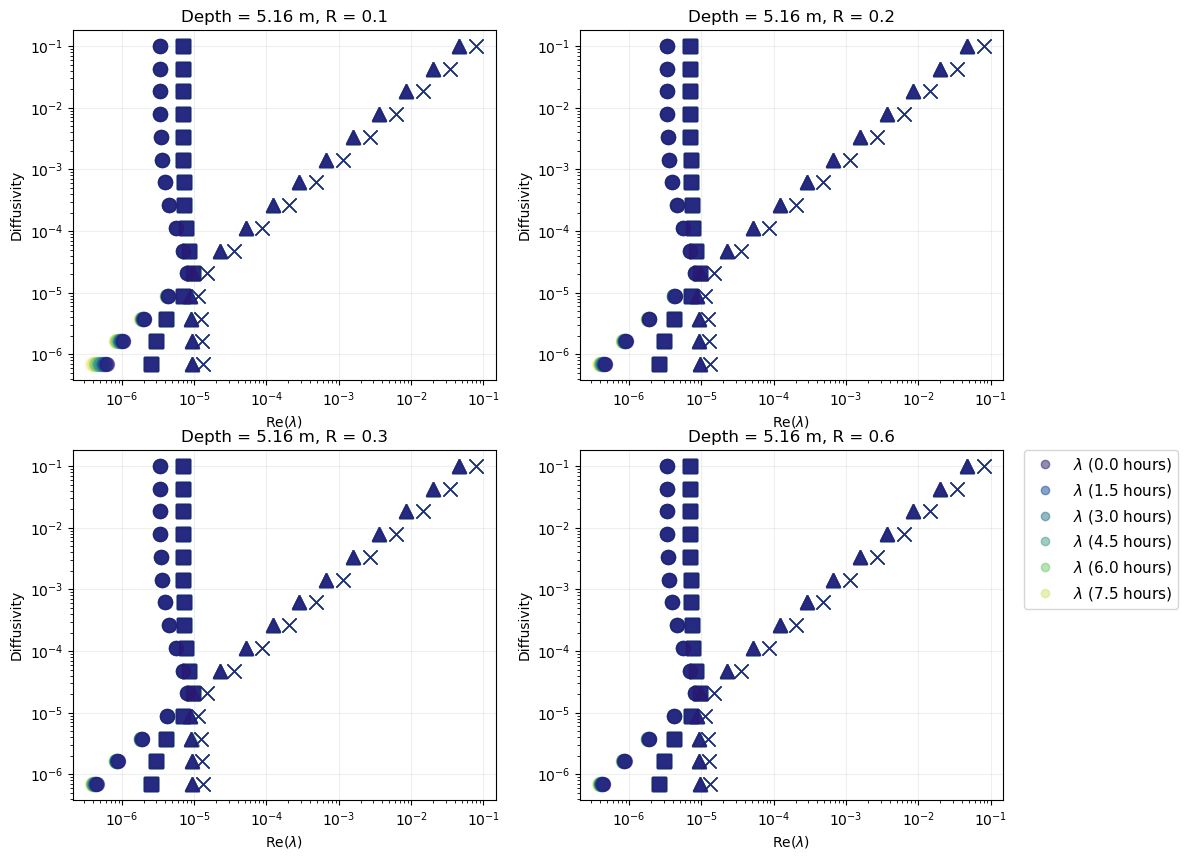

In [2]:
# Snapshot of three time frames 
TIMES = list(range(0, 300, 25)) 

id = 2
ir = 14

# Depth = 5.00 m, R = 0.6, Kappa = 2e-04 (interesting)
depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
h1 = ratio * depth
h2 = depth - h1

# txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)

shapes = ['o', 's', '^', 'x', 'v']
variables = ["M_1", "M_2", "D_1", "D_2", "N_1"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
axs = axs.flatten()
for ax in axs:
    ax.grid(alpha=0.2)
    ax.axhline(y=0, color='k', alpha=0.5)
    ax.axvline(x=0, color='k', alpha=0.5)
    ax.set_ylabel("Diffusivity")
    ax.set_xlabel("Re($\lambda$)")
    ax.set_yscale('log')
    ax.set_xscale('log')
irs = [0, NV//4, NV//2, NV-1]
for ix, ax in enumerate(axs):
    ir = irs[ix]
    ratio = dst.ratio.values[ir]
    txt = "Depth = %2.2f m, R = %2.1f" % (depth, ratio)
    ax.set_title(txt)
    for ik in range(0, 15, 1):
        kappa = dst.kappa.values[ik]          
        for it in TIMES: 
            hour = dst.t.values[it]/3600
            m1 = dst.m1.values[it, id ,ir, ik]
            m2 = dst.m2.values[it, id ,ir, ik]
            n1 = dst.n1.values[it, id ,ir, ik]
            d1 = dst.d1.values[it, id ,ir, ik]
            d2 = dst.d2.values[it, id ,ir, ik]
            eigenvalues, ev = pm.jacobian_2s(kappa, h1, h2, m1, m2, d1, d2, n1)
            for e, eig in enumerate(eigenvalues):
                if eig.real < 0:
                    eigenvalues[e] = -eig
                    ev[e] = -ev[e]               
            eigenvalues = sorted(eigenvalues)
            vector0 = np.array([m1, m2, n1])
            color = cmo.cm.haline_r(it/max(TIMES))

            for ie, eigenvalue in enumerate(eigenvalues[0:4]):
                # if eigenvalue.real<0:
                #     vector0 = -vector
                # else:
                #     vector0 = vector
                ev0 = ev[ie]/ np.linalg.norm(ev[ie])
                vector0 = vector0/ np.linalg.norm(vector0)
                if eigenvalue.imag != 0:
                    print("Complex eigenvalue!", eigenvalue.imag)
                if ((it%2) == 0):
                    ax.plot(abs(eigenvalue.real), kappa, shapes[ie], color=color, alpha=0.5, markersize=10) #, label=r"$\lambda_%d$ (%2.1f hours)" % (ie, hour), )
                    # ax2.plot(ev0.dot(vector0), kappa, shapes[ie],  color=color, alpha=0.5)#,  label=r"$V_%d$ (%2.1f hours)" % (ie, hour))
                else:
                    ax.plot(abs(eigenvalue.real), kappa, shapes[ie],  color=color, alpha=0.5, markersize=10)
                    # ax2.plot(ev0.dot(vector0), kappa, shapes[ie],  color=color, alpha=0.5)
                    # print(ev[ie].dot(ev[ie+1])) 

for it in TIMES[::2]:
    hour = dst.t.values[it]/3600
    ax.plot([],[], 'o', alpha=0.5, color = cmo.cm.haline(it/max(TIMES)),  label=r"$\lambda$ (%2.1f hours)" % (hour)) 

ax.legend(bbox_to_anchor=(1.05, 1), ncols=1, loc='upper left', borderaxespad=0., fontsize=11,)
fn = txt.replace(",", "_")
# fig.savefig("eigens/%s.png" % fn, dpi=300)



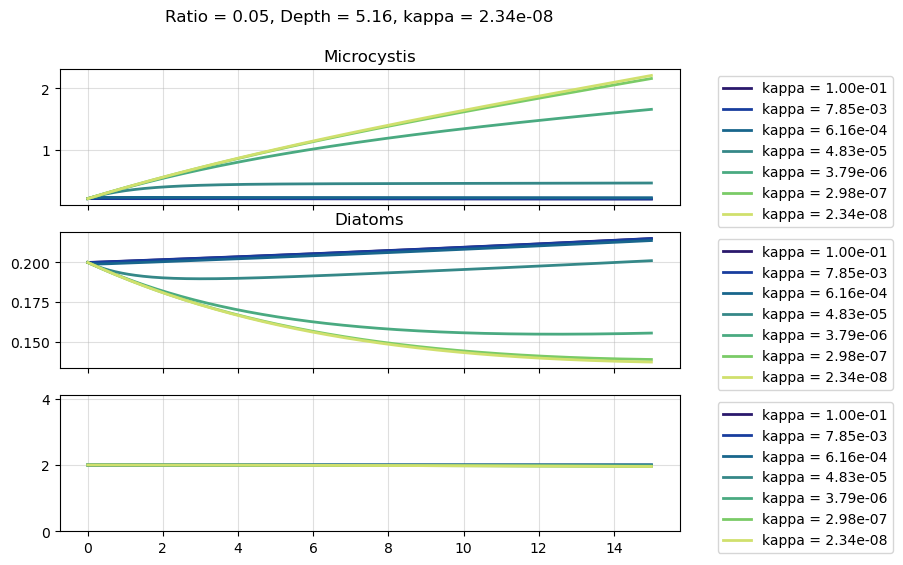

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,6), sharex=True, sharey=False)

ik = 10
id = 2
ir = 0 

for ik in range(0, NV, 3):
    color = cmo.cm.haline(ik/NV)

    total = (dst.m1[:, id, ir, ik] + dst.m2[:, id, ir, ik])/1e6
    axs[0].plot(dst.t.values/3600, total, 
            color=color,
            linewidth=2,
            label="kappa = %2.2e" % dst.kappa.values[ik])
    axs[1].plot(dst.t.values/3600, dst.d1[:, id, ir, ik]/1e6 + dst.d1[:, id, 8, ir]/1e6, 
            color=color,
            linewidth=2,
            label="kappa = %2.2e" % dst.kappa.values[ik])

    axs[2].plot(dst.t.values/3600, dst.n1[:, id, ir, ik], 
            color=color,
            linewidth=2,
            label="kappa = %2.2e" % dst.kappa.values[ik])
#     print(dst.n1[:, id ,ir, ik].values)
axs[1].set_title("Diatoms")
axs[0].set_title("Microcystis")

title = "Ratio = %2.2f, Depth = %2.2f, kappa = %2.2e" % (dst.ratio.values[ir], dst.depth.values[id], dst.kappa.values[ik])
plt.suptitle(title)

axs[2].set_ylim(0, 4.1)
for ax in axs:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(alpha=0.4)


200000.0


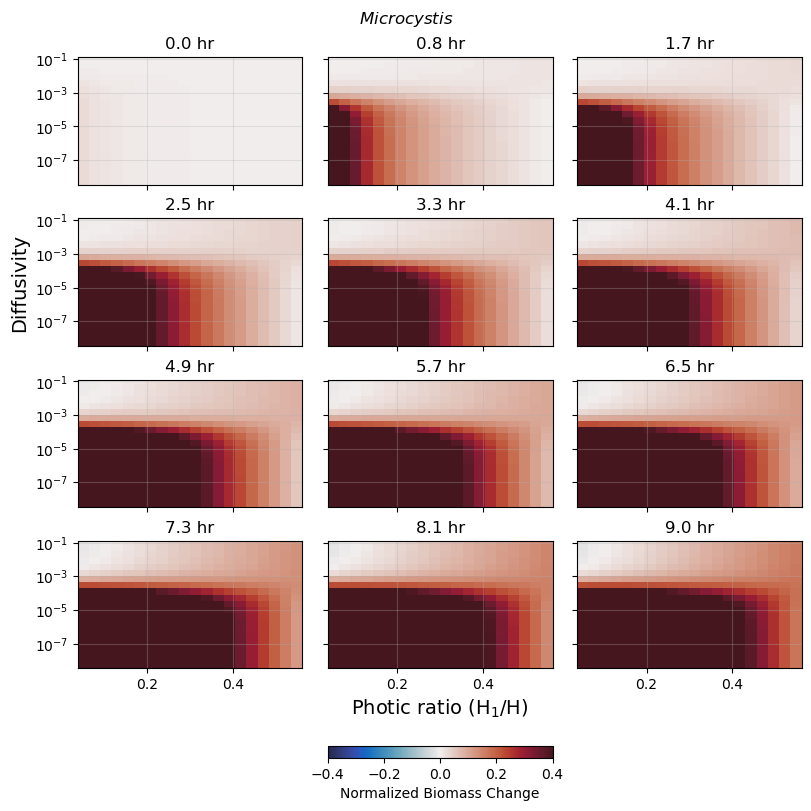

In [4]:

init_biomass = dst.m1.values[0, 0 ,0,0] + dst.m2.values[0, 0 ,0,0]
print(init_biomass)
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()


# norm 
norm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=0, vmax=0.25)


def normalize_color2(value):
    c = (value - init_biomass) / init_biomass
    # c = c.clip(-3, 3)
    return c


def reshape_(data, N):
    return np.array(data).reshape(N, -1)


id = 2

depth = dst.depth.values[id]
fig.suptitle("Depth = %2.2f" % depth)

KAPPA  = dst.kappa.values
RATIO = dst.ratio.values 


NT = 300 
for i, it in enumerate(range(1, NT, NT//11)):
    # color = cmo.cm.haline(it/NT)
    BIOMASS_M = dst.m1.values[it, id, :, :] + dst.m2.values[it, id, :, :]
    relative = normalize_color2(BIOMASS_M) #reshape_(BIOMASS_M, N))

    axs[i].set_yscale('log')

    axs[i].set_title("%2.1f hr" % (dst.t.values[it]/3600))

    h = axs[i].pcolormesh(RATIO, KAPPA,
                relative.T, linewidths=4, alpha=0.95, cmap=cmo.cm.balance, vmin=-4e-1, vmax=4e-1) 

plt.colorbar(h, label='Normalized Biomass Change', orientation='horizontal',  pad=0.2, ax=axs[-2])

axs[3].set_ylabel("Diffusivity", fontsize=14)
axs[-2].set_xlabel("Photic ratio (H$_1$/H)", fontsize=14)
plt.suptitle("$Microcystis$")
for ax in axs:
    ax.grid(alpha=0.3)

200000.0


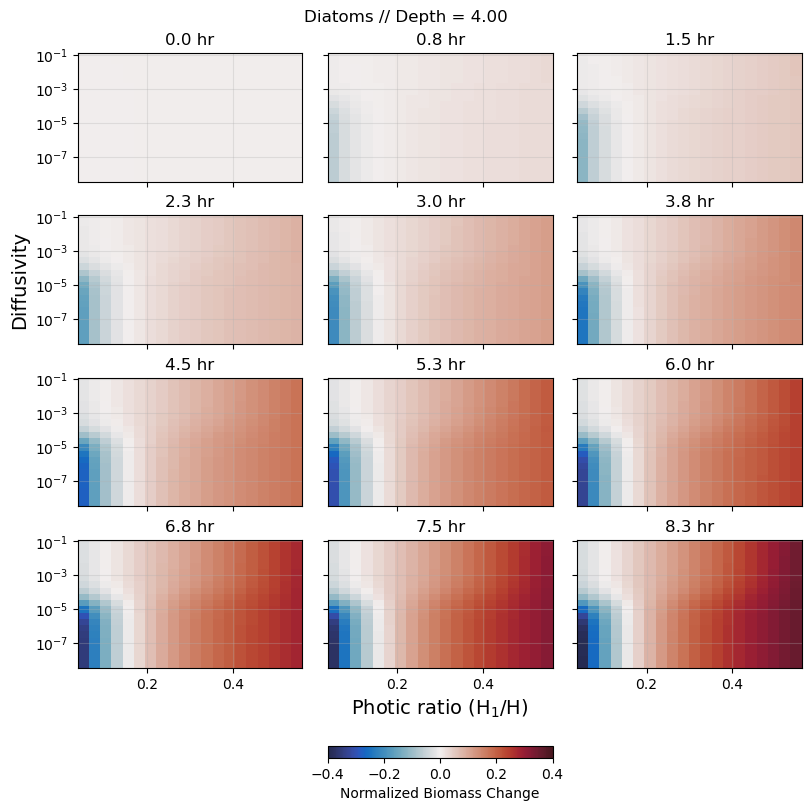

In [5]:

init_biomass = dst.d1.values[0, 0 ,0,0] + dst.d2.values[0, 0 ,0,0]
print(init_biomass)


fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()


def normalize_color2(value):
    c = (value - init_biomass) / init_biomass
    # c = c.clip(-3, 3)
    return c


def reshape_(data, N):
    return np.array(data).reshape(N, -1)


id = 0

depth = dst.depth.values[id]
fig.suptitle("Diatoms // Depth = %2.2f" % depth)

KAPPA  = dst.kappa.values
RATIO = dst.ratio.values 

NT = 300 
for i, it in enumerate(range(1, NT, NT//12)):
    # color = cmo.cm.haline(it/NT)
    BIOMASS_D = dst.d1.values[it, id, :, :] + dst.d2.values[it, id, :, :]
    
    relative = normalize_color2(BIOMASS_D)

    axs[i].set_yscale('log')

    axs[i].set_title("%2.1f hr" % (dst.t.values[it]/3600))

    h = axs[i].pcolormesh(RATIO, KAPPA,
                relative.T, linewidths=4, alpha=0.95, cmap=cmo.cm.balance, vmin=-4e-1, vmax=4e-1) 

plt.colorbar(h, label='Normalized Biomass Change', orientation='horizontal',  pad=0.2, ax=axs[-2])

axs[3].set_ylabel("Diffusivity", fontsize=14)
axs[-2].set_xlabel("Photic ratio (H$_1$/H)", fontsize=14)

for ax in axs:
# ax.plot([], [], color=color, label="%2.1f hr" % (dst.t.values[it]/3600), linewidth=4, alpha=0.5)
    # ax.set_xlabel("Photic ratio (H$_1$/H)")
    # ax.set_ylabel("Diffusivity")
    # # ax.legend(ncols=2, bbox_to_anchor=(1.05, 1), loc='upper left', title="Time")
    # ax.set_title("Microcystis")
    ax.grid(alpha=0.3)

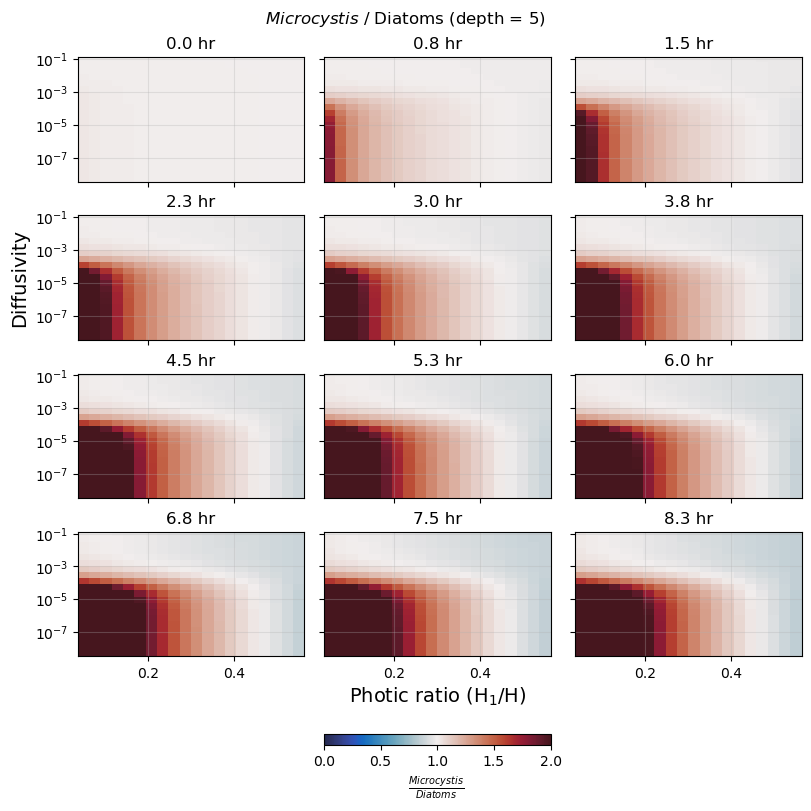

In [138]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()

# norm 
norm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=0, vmax=0.25)


def reshape_(data, N):
    return np.array(data).reshape(N, -1)

id = 2
depth = dst.depth.values[id]
fig.suptitle("Depth = %2.2f" % depth)

KAPPA  = dst.kappa.values
RATIO = dst.ratio.values 

NT = 300 
for i, it in enumerate(range(1, NT, NT//12)):
    # color = cmo.cm.haline(it/NT)
    BIOMASS_M = dst.m1.values[it, id, :, :] + dst.m2.values[it, id, :, :]
    BIOMASS_D = dst.d1.values[it, id, :, :] + dst.d2.values[it, id, :, :]
    ratio_biomass = BIOMASS_M / (BIOMASS_D)
    axs[i].set_yscale('log')

    axs[i].set_title("%2.1f hr" % (dst.t.values[it]/3600))

    h = axs[i].pcolormesh(RATIO, KAPPA,
                ratio_biomass.T, linewidths=4, alpha=0.95, cmap=cmo.cm.balance, vmin=0, vmax=2) 

plt.colorbar(h, label=r'$\frac{Microcystis}{Diatoms}$ ', orientation='horizontal',  pad=0.2, ax=axs[-2])

axs[3].set_ylabel("Diffusivity", fontsize=14)
axs[-2].set_xlabel("Photic ratio (H$_1$/H)", fontsize=14)
plt.suptitle("$Microcystis$ / Diatoms (depth = %d)" % depth)
for ax in axs:
    ax.grid(alpha=0.3)

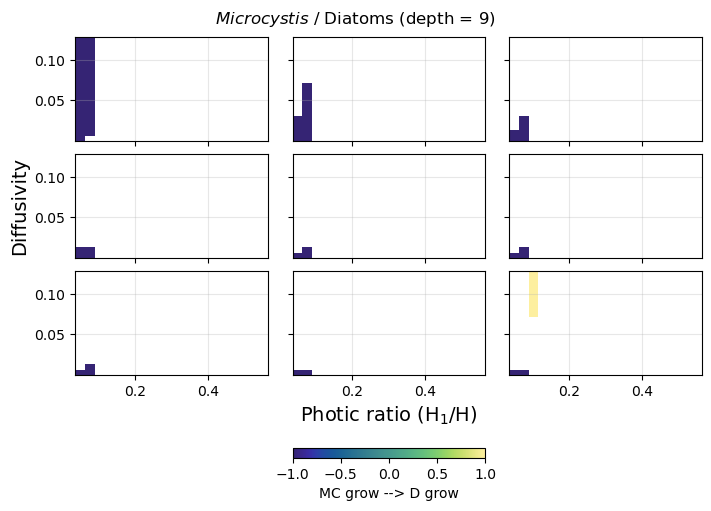

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7, 5), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()

# norm 
norm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=0, vmax=0.25)


def reshape_(data, N):
    return np.array(data).reshape(N, -1)

id = 10
depth = dst.depth.values[id]
fig.suptitle("Depth = %2.2f" % depth)

KAPPA  = dst.kappa.values
RATIO = dst.ratio.values 

NT = 300 
for i, it in enumerate(range(1, NT, NT//8)):
    # color = cmo.cm.haline(it/NT)
    BIOMASS_M = dst.m1.values[it, id, :, :] + dst.m2.values[it, id, :, :]
    BIOMASS_D = dst.d1.values[it, id, :, :] + dst.d2.values[it, id, :, :] 

    diff_m = BIOMASS_M - init_biomass
    diff_d = BIOMASS_D - init_biomass

    grows = np.zeros_like(BIOMASS_M) + np.nan
    grows[(diff_m > 0) & (diff_d < 0)] = -1

    grows[(diff_m < 0) & (diff_d > 0)] = 1

    h = axs[i].pcolormesh(RATIO, KAPPA,
                grows.T, linewidths=4, alpha=0.95, cmap=cmo.cm.haline, vmin=-1, vmax=1) 

plt.colorbar(h, label=r'MC grow --> D grow', orientation='horizontal',  pad=0.2, ax=axs[-2])

axs[3].set_ylabel("Diffusivity", fontsize=14)
axs[-2].set_xlabel("Photic ratio (H$_1$/H)", fontsize=14)
plt.suptitle("$Microcystis$ / Diatoms (depth = %d)" % depth)
for ax in axs:
    ax.grid(alpha=0.3)

200000.0


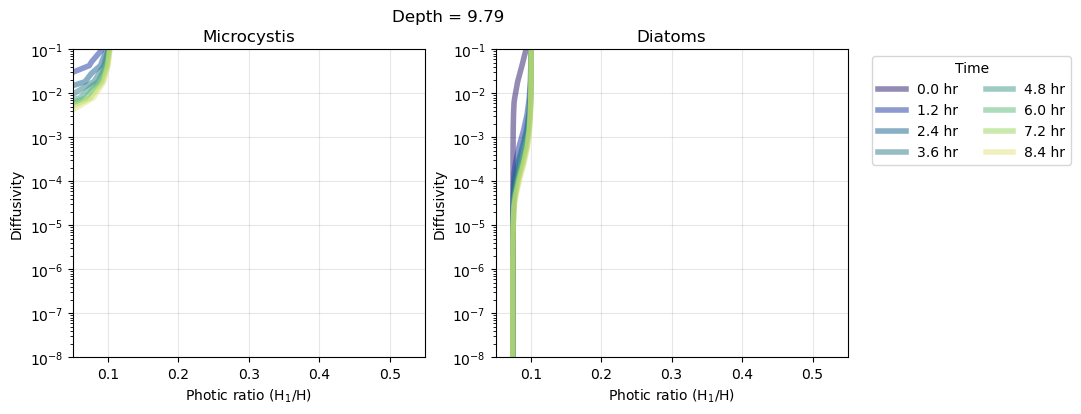

In [7]:
init_biomass = dst.m1.values[0, 0 ,0,0] + dst.m2.values[0, 0 ,0,0]
print(init_biomass)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs = axs.flatten()

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel("Photic ratio (H$_1$/H)")
    ax.set_ylabel("Diffusivity")
    
    ax.grid(alpha=0.3)
# norm 


def reshape_(data, N):
    return np.array(data).reshape(N, -1)


id = 10
depth = dst.depth.values[id]
fig.suptitle("Depth = %2.2f" % depth)

KAPPA  = dst.kappa.values
RATIO = dst.ratio.values 

axs[0].set_title("Microcystis")
axs[1].set_title("Diatoms")

for it in range(1, NT, 40):

    color = cmo.cm.haline(it/NT)
    BIOMASS_M = dst.m1.values[it, id, :, :] + dst.m2.values[it, id, :, :]
    BIOMASS_D = dst.d1.values[it, id, :, :] + dst.d2.values[it, id, :, :]
    axs[0].contour(RATIO, KAPPA,
                normalize_color2(BIOMASS_M).T, levels=[0], linewidths=4, alpha=0.5, colors=color) 
    axs[1].contour(RATIO, KAPPA,
                normalize_color2(BIOMASS_D).T, levels=[0], linewidths=4, alpha=0.5, colors=color) 
    axs[1].plot([], [], color=color, label="%2.1f hr" % (dst.t.values[it]/3600), linewidth=4, alpha=0.5)

axs[1].legend(ncols=2, bbox_to_anchor=(1.05, 1), loc='upper left', title="Time")


In [ ]:
# fig = plt.figure(figsize=(8,3))



# id = 5
# ir = 5
# ik = 1

# colors = ["#164F73", "#75A653", "#F2BC79", "#D9665B"]

# times = dst.t.values/3600
# axp = plt.gca()

# depth = dst.depth.values[id]

# growth_m = 1.08e-5              # 1/s 
# half_sat_m1 = 0.18              # µmol P / L
# max_uptake_m1 = 2.23e-12        # µmol P / cell s 
# half_sat_n1_m = 1.23            # µmol P / L


# ratio = dst.ratio.values[ir]
# h1 = depth*ratio
# h2 = depth - h1

# depth = dst.depth.values[id]
# kappa = dst.kappa.values[ik]



# kappa = dst.kappa.values[ik]
# advection = dst.m2.values[:, id ,ir,ik]*wm/h1 
# diffusion = kappa/h1*(dst.m2.values[:, id ,ir,ik] - dst.m1.values[:, id ,ir,ik])

# m1 = dst.m1.values[:, id ,ir,ik]
# n1 = dst.n1.values[:, id ,ir,ik]

# growth = (growth_m * m1*(n1/(half_sat_m1 + n1)))  #growth_m * dst.m1.values[:, id ,ir,ik] *  dst.n1.values[:, id ,ir,ik] 


# loss = Lm * dst.m1.values[:, id ,ir*2,ik]
# axp.plot(times, advection, '-k', alpha=0.5, label="(+) advection")
# axp.plot(times, -diffusion, '--r', label="(-) diffusion", alpha=0.5)
# axp.plot(times, loss, '-r', label="(-) loss")
# axp.plot(times, growth, '-.k', label="(+) growth")
# gl = growth - loss

# # axp.set_yscale("log")
# axp.set_xlabel("Hours")
# axp.grid( alpha=0.35)
# axp.legend()
# axp.set_title("Depth = %2.2f m, Kappa = %2.1e, Ratio = %2.1f" % (depth, kappa, ratio))


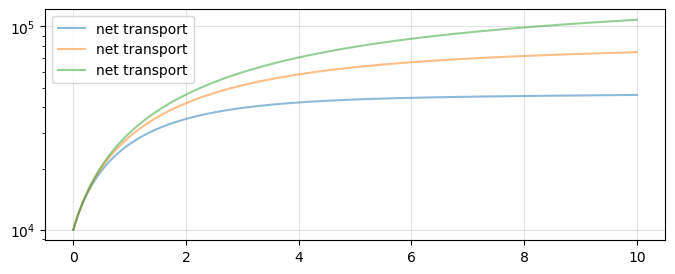

In [ ]:


fig = plt.figure(figsize=(8,3))
id = 1 
ir = 2
ik = 13

colors = ["#164F73", "#75A653", "#F2BC79", "#D9665B"]

axp = plt.gca()

depth = dst.depth.values[id]
for ir in range(0,1):
    ratio = dst.ratio.values[ir*2]
    h1 = depth*ratio
    h2 = depth - h1
    for ik in range(11, 14):
        kappa = dst.kappa.values[ik]

        axp.plot(dst.t.values/3600, dst.m1.values[:, id ,ir*2,ik], '-', alpha=0.5, label="net transport")
        # axp.plot(dst.t.values/3600, -diffusion, '--', label="diffusion", alpha=0.5)

        # gradient = np.gradient(dst.m1.values[:, id ,ir*2,ik], dst.t.values)
        # index = np.where(gradient < 0)[0][0]
        # print("@ kappa = %2.2e" % dst.kappa.values[ik])
        # print("starts dying at t= %2.2f" % (dst.t.values[index]/3600))
        # axp.plot(dst.kappa.values[ik], dst.t.values[index]/3600, 'o', color=colors[ir])
# print(gradient)
axp.set_yscale("log")
# axp.set_ylabel("Hours")
# axp.set_xlabel("Kappa (m/s)")
axp.grid( alpha=0.35)
# axp.set_xlim(0, 40)
axp.legend()

$$ J  = \begin{bmatrix}
    -\frac{\kappa}{H_1} + \alpha \left(\frac{N_1}{\gamma_M + N_1}\right) - L_m & 
    \frac{\kappa}{H_1} +  \frac{w_m}{H_1}  & \alpha M_1 \left( \frac{\gamma_M}{(N_1 + \gamma_M)^2} \right) \\
    \frac{\kappa}{H_2} & -\frac{w_m}{H_2} - \frac{\kappa}{H_2} - L_m 
     & 0  \\
       - U_{m} \left(\frac{N_1}{N_1 + \gamma_{NM}}\right)  & 0  & -\frac{\kappa}{H_1}  - U_M M_1 \left(\frac{\gamma_{NM}}{(N_1 + \gamma_{NM})^2} \right) \\
\end{bmatrix}$$



In [ ]:

    


def steady_state(H, R, kappa, d2, m2, n1):

    # Solution 1:
    d1 = -d2*kappa/(-H*Ld*R + H*R*growth_d*n1 - kappa - wd)
    m1 = (-kappa*m2 - m2*wm)/(-H*Lm*R + H*R*growth_m*n1 - kappa)

    return (d1, m1)






In [8]:
id = 3
ik = 12
ir = 2

depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
kappa = dst.kappa.values[ik]

m1 = dst.m1.values[:, id ,ir,ik]
d1 = dst.d1.values[:, id ,ir,ik]
d2 = dst.d2.values[:, id ,ir,ik]
m2 = dst.m2.values[:, id ,ir,ik]
n1 = dst.n1.values[:, id ,ir,ik]
txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)

# m1_eq, d1_eq = steady_state(depth, ratio, kappa, d2, m2, n1)
print("depth = %2.2f, ratio = %2.2f, kappa = %1.0e" % (depth, ratio, kappa))

depth = 5.74, ratio = 0.10, kappa = 4e-06


In [10]:
def set_up_phase_axes(fig, axs): 
    axs = axs.flatten()

    gs = axs[1].get_gridspec()

    axs[0].remove()
    axs[1].remove()
    axs[2].remove()

    axs[3].remove()
    axs[4].remove()
    axs[5].remove()

    axphase = fig.add_subplot(gs[0:, 0])
    axp = fig.add_subplot(gs[1:3])
    axn = fig.add_subplot(gs[4:6])
    return axphase, axp, axn


def plot_pop_ax(ax, id, ir, ik):
    ax.plot(dst.t.values/3600, dst.m1.values[:, id ,ir,ik]/1e6, label=r"Microcystis", color='#0F9BF2', linewidth=3)
    ax.plot(dst.t.values/3600, dst.d1.values[:, id ,ir,ik]/1e6, label=r"Diatoms", color='#5CA612', linewidth=3)
    ax.plot(dst.t.values/3600, dst.m2.values[:, id ,ir,ik]/1e6, '--', label=r"Bottom Microcystis", color='#0F9BF2', linewidth=1)
    ax.plot(dst.t.values/3600, dst.d2.values[:, id ,ir,ik]/1e6, '--',  label=r"Bottom Diatoms", color='#5CA612', linewidth=1)
    ax.grid(alpha=0.2)
    ax.set_ylabel("Biomass")
    ax.set_xlabel("Time (hours)")
    ax.legend(loc='upper right')


In [18]:
NN = 3

# MM = 3e6
M0 = 0.5e6 #890000
M00 = -M0 #M0*0.6

id = 3
ik = 5
ir = 2

depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
kappa = dst.kappa.values[ik]

txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)

x = np.linspace(M00, M0, NN)
y = np.linspace(M00, M0, NN)
X, Y = np.meshgrid(x, y)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 4), sharey=False, sharex=False)
txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)
fig.suptitle("Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa))

axphase, axp, axn = set_up_phase_axes(fig, axs)

axn.plot(dst.t.values/3600, dst.n1.values[:, id ,ir,ik], color='#BF0F0F', linewidth=3)
biomass_m = (dst.m1.values[:, id ,ir,ik] + dst.m2.values[:, id ,ir,ik])/1e6
biomass_d = (dst.d1.values[:, id ,ir,ik] + dst.d2.values[:, id ,ir,ik])/1e6

plot_pop_ax(axp, id, ir, ik)

axphase.plot(dst.m1.values[0, id ,ir,ik], dst.d1.values[0, id ,ir,ik], '^', color='k', alpha=0.3, linewidth=4)
axphase.grid(alpha=0.2)
axn.grid(alpha=0.2)


axn.set_ylabel("Surface nutrients")
axn.set_xlabel("Time (hours)")
axn.set_xlim(0, dst.t.values[-1]/3600)
axp.set_xlim(0, dst.t.values[-1]/3600)

axn.hlines(1e-5, 0, dst.t.values[-1]/3600, colors='#BF0F0F', linestyles='dashed', alpha=0.5)

R = dst.ratio.values[ir]
H = dst.depth.values[id]
distances = [] 
for it in range(0, 500, 50):
    
    d1 = dst.d1.values[it, id ,ir,ik]
    d2 = dst.d2.values[it, id ,ir,ik] # (time, depth, ratio, kappa) 
    m1 = dst.m1.values[it, id ,ir,ik]
    m2 = dst.m2.values[it, id ,ir,ik]
    n1 = dst.n1.values[it, id ,ir,ik]

    U, V = np.zeros_like(X), np.zeros_like(Y)
    # Compute derivatives on grid
    for i in range(NN):
        for j in range(NN):
                f1, f2, f3, f4, f5 = pm.field_at_point_2s(R, H, kappa, X[i,j], m2, Y[i,j], d2, n1, n2=2)
                U[i,j] = f1
                V[i,j] = f3

    axp.plot(dst.t.values[it]/3600, m1/1e6 , 'o', color='#0F9BF2')
    axp.plot(dst.t.values[it]/3600, d1/1e6 , 'o', color='#5CA612')
    axn.plot(dst.t.values[it]/3600, n1 , 'o', color='#BF0F0F')

    axphase.plot([M00, M0], [M00, M0], '--', color='black', alpha=0.15)
    axphase.set_xlabel(r"$M_1$")
    axphase.set_ylabel(r"$D_1$")
    axphase.plot(dst.m1.values[0:it, id ,ir,ik], dst.d1.values[0:it, id ,ir,ik], '-', color='#5CA612', alpha=0.3, linewidth=4)
    axphase.plot(m1, d1, 'o', color='#5CA612', markersize=10)
    axphase.streamplot(x, y, U, V,  color="gray")
    d11, m11 = pm.steady_state_2s(ratio, depth, kappa, d2, m2, n1) #steady_state(depth, ratio, kappa, d2, m2, n1)
    if (d11<0) or (m11<0):
        print("Negative steady state!")
        print(m11, d11)
        axphase.plot(m11, d11, 'X', color="#A61281", markersize=10)

    else:
        axphase.plot(m11, d11, 'X', color="#A61281", markersize=10)
    distance = np.sqrt((m11/1e6 - m1/1e6)**2 + (d11/1e6 - d1/1e6)**2)

    distances.append(distance)
    plt.tight_layout()
    # plt.show()

    axphase.set_xlim(M00, M0)
    axphase.set_ylim(M00, M0)
    axphase.hlines(0, M00, M0, colors='k', alpha=0.4)
    axphase.vlines(0, M00, M0, colors='k', alpha=0.4)
    # # assert(False)
    fig.savefig("gif/t_%03d.png" % it, dpi=150)

    axphase.cla()
    for art in list(axphase.lines[1:]):
        art.remove()
    for art in list(axn.lines[1:]):
        art.remove()
    for art in list(axp.lines[4:]):
        art.remove()
plt.close()


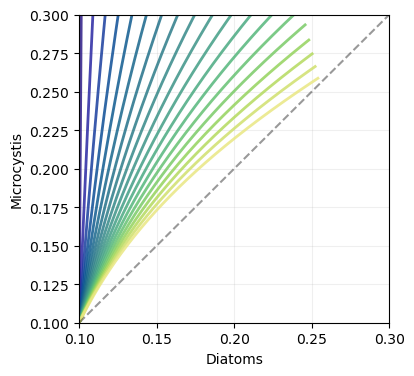

In [65]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca() 

NT = 500
id = 10
ir = 18
ik = 19

for iv in range(0, NV, 1):
    
    ir = iv 
    d1 = dst.d1.values[it, id ,ir,ik]
    d2 = dst.d2.values[it, id ,ir,ik] # (time, depth, ratio, kappa) 
    m1 = dst.m1.values[it, id ,ir,ik]
    m2 = dst.m2.values[it, id ,ir,ik]
    n1 = dst.n1.values[it, id ,ir,ik]

    # ax.plot(d11, m11, '^', color=cmo.cm.haline(it/NT), markersize=10)
    # ax.plot(d1, m1, 'o', color=cmo.cm.haline(it/NT), markersize=10)
    ax.plot(dst.d1.values[:,id ,ir,ik]/1e6, dst.m1.values[:,id ,ir,ik]/1e6, alpha=0.85, color=cmo.cm.haline(iv/NV), linewidth=2)

ax.set_ylabel("Microcystis")
ax.set_xlabel("Diatoms")

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(alpha=0.2)
ax.set_xlim(0.1, 0.3)
ax.set_ylim(0.1, 0.3)
ax.plot([0, 0.4], [0, 0.4], '--', color='k', alpha=0.4)
# ax.plot(d1*0.9, d1*1.5)

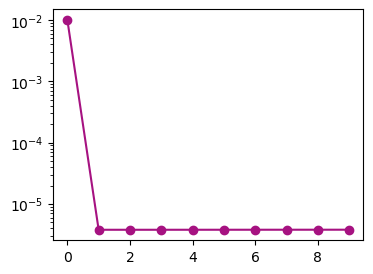

In [62]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.plot( distances, '-o', color='#A61281')
ax.set_yscale('log')

In [212]:
import imageio
import os

folder  = "gif/"
images = []
for file_name in sorted(os.listdir(folder)):
    if file_name.endswith('.png'):
        file_path = os.path.join(folder, file_name)
        images.append(imageio.imread(file_path))
imageio.mimwrite('time_evolution_%s.gif' % txt, images, fps=3)
print(txt)

/tmp/ipykernel_908015/1301611190.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


Depth = 15.00 m, R = 0.3, Kappa = 8e-03


Depth = 9.21 m, Ratio = 0.31
0.4243991762726046
0.055902398066502205
-0.5648459492590941
-0.35226811438303407
0.4999999998126669

kappa = 4e-02
it = 0, hour = 0.0
0.42400437699756005
0.055044500804866094
-0.5653252587963163
-0.35289820045542875
0.5000959494616611

kappa = 4e-02
it = 1, hour = 0.0
0.42393024525246575
0.054922886926363775
-0.5653429487898309
-0.35294865758328964
0.5001656584511253

kappa = 4e-02
it = 2, hour = 0.1
0.4238869835635696
0.05487211117690006
-0.565316325637321
-0.3529432899435237
0.5002328334532014

kappa = 4e-02
it = 3, hour = 0.1
theta [64.88736084 64.91234002 64.91702981 64.91976658]
theta [86.79535792 86.84458762 86.85156614 86.85447977]
theta [124.39159444 124.42488091 124.42610967 124.42426041]
theta [110.62610603 110.66468481 110.66777461 110.66744592]
theta [60.00000001 59.99365183 59.98903952 59.98459467]
0.38519766332997396
0.04077279111371592
-0.5504682160583292
-0.36432618240140036
0.49999925905580445

kappa = 6e-04
it = 0, hour = 0.0
0.38401363045

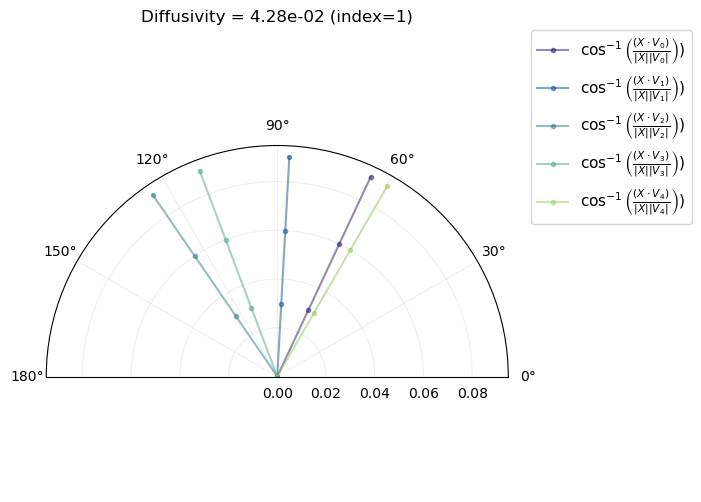

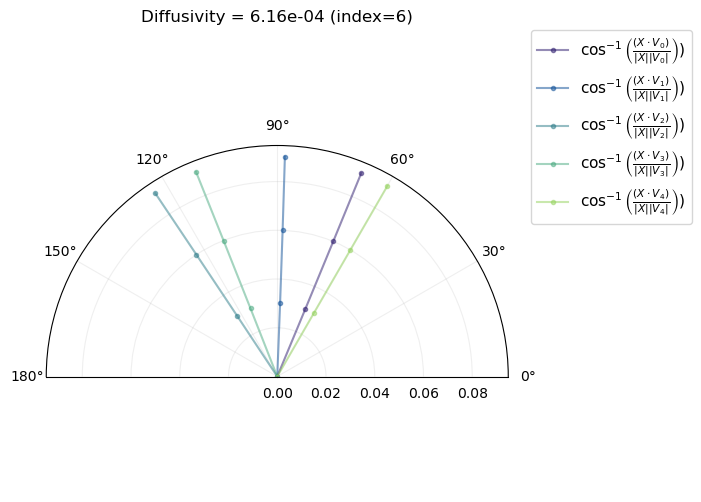

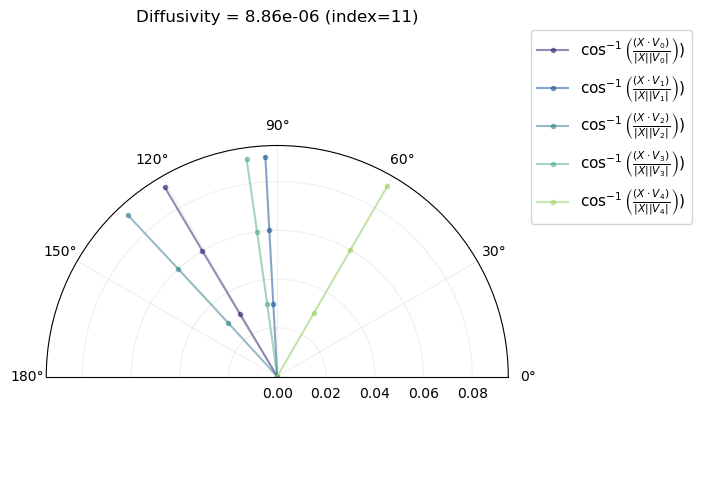

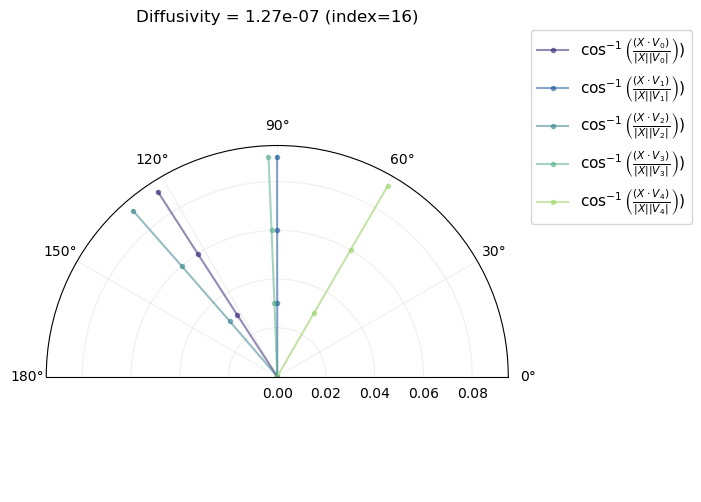

In [ ]:
# Polar plot
TIMES = list(range(0, 4, 1)) 


id = 9
ir = 10
print("Depth = %2.2f m, Ratio = %2.2f" % (dst.depth.values[id], dst.ratio.values[ir]))

hours = [dst.t.values[i]/3600 for i in TIMES]
for ik in range(1, 20, 5):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='polar')

    ax.grid(alpha=0.2)

    ax.set_title("Diffusivity = %2.2e (index=%d)" % (dst.kappa.values[ik], ik))
    kappa = dst.kappa.values[ik]
    
    # d1 = dst.d1.values[0, id ,ir, ik] 
    # d2 = dst.d2.values[0, id ,ir, ik] # (time, depth, ratio, kappa) 
    # m1 = dst.m1.values[0, id ,ir, ik] 
    # m2 = dst.m2.values[0, id ,ir, ik]
    # n1 = dst.n1.values[0, id ,ir, ik] 
    # state_vector0 = np.array([m1, m2, d1, d2, n1])
    theta = np.zeros((len(TIMES), 5))

    for i, it in enumerate(TIMES): 

        hour = dst.t.values[it]/3600
        d1 = dst.d1.values[it, id ,ir, ik]
        d2 = dst.d2.values[it, id ,ir, ik] # (time, depth, ratio, kappa) 
        m1 = dst.m1.values[it, id ,ir, ik]
        m2 = dst.m2.values[it, id ,ir, ik]
        n1 = dst.n1.values[it, id ,ir, ik]
        eigenvalues, ev = pm.jacobian_2s(kappa, h1, h2, m1, m2, d1, d2, n1)
        state_vector = np.array([m1, m2, d1, d2, n1])

        # Iterate through the eigenvectors
        for iv, vector in enumerate(ev): 
            cos0 =  np.dot(state_vector, vector) / (np.linalg.norm(state_vector) * np.linalg.norm(vector)) 
            theta[i, iv]  = np.arccos(cos0)


        print("\nkappa = %1.0e" % kappa)  
        print("it = %d, hour = %2.1f" % (it, hour))

    for c in range(0,5):
        print("theta", np.rad2deg(theta[:,c])) 
        ax.plot(theta[:,c], hours, '.-', color=cmo.cm.haline(c/5), alpha=0.5, label=r'$\cos^{-1} \left( \frac{(X \cdot V_%d)}{ |X| |V_%d|} \right)$)' % (c,c)) # Theta= cos^-1 (u dot v / |v| |u|).
        # ax.plot(hours,theta[:,c], '-o', color=cmo.cm.deep(c/5), alpha=0.5, label=r'$\cos^{-1} \left( \frac{(X \cdot V_%d)}{ |X| |V_%d|} \right)$)' % (c,c)) # Theta= cos^-1 (u dot v / |v| |u|).

    ax.legend(bbox_to_anchor=(1.05, 1), ncols=1, loc='upper left', borderaxespad=0., fontsize=11)
    ax.set_thetamin(0)
    ax.set_thetamax(180)